In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [19]:
tree_names = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [20]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [21]:
files[3].aliases = {
    'B_FD_TRUE': "D_FD_TRUE",
}

In [22]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [23]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [24]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [25]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [26]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [27]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [28]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [29]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [30]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          955868   243424  194739   48685       0.254663
B⁺→K⁺J/ψ(→ee)    946366   916346  733076  183270       0.968279
B⁺→K⁺ψ(2S)(→ee)  972093   926218  740974  185244       0.952808
D⁺→π⁺φ(→ee)      822647   822647  658117  164530            1.0

### KS tests

In [31]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [32]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [33]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [34]:
aliases = {
    "min_e_IP": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
}

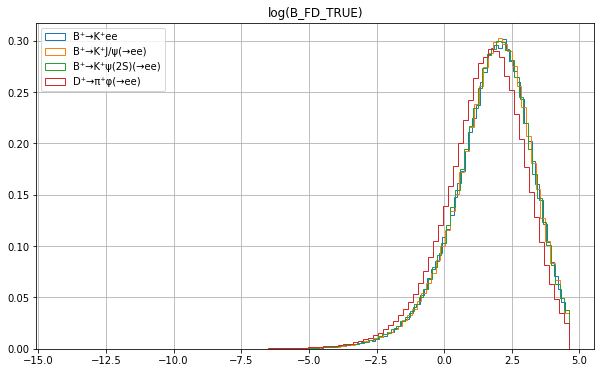

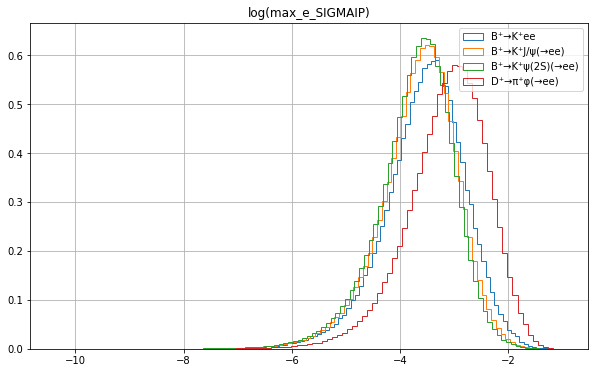

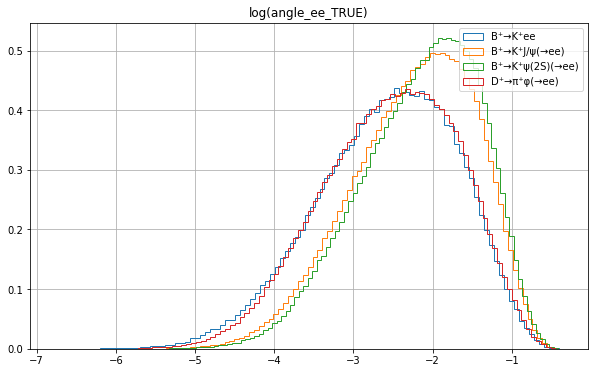

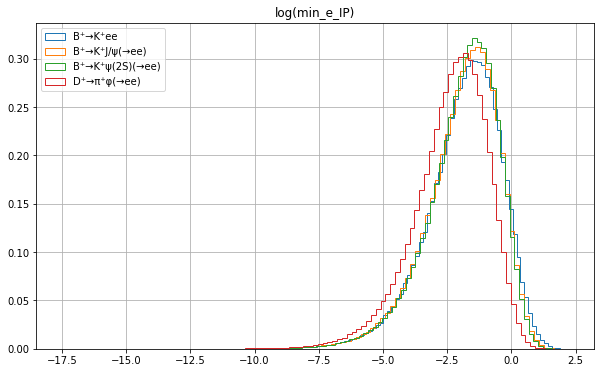

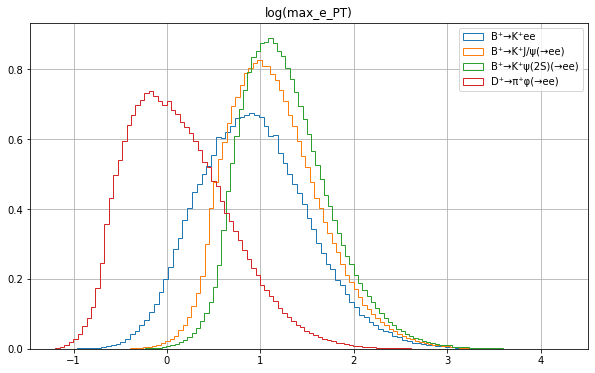

In [35]:
feature_plot("log(B_FD_TRUE)", train_ds, aliases, 101)
feature_plot("log(max_e_SIGMAIP)", train_ds, aliases, 101)
feature_plot("log(angle_ee_TRUE)", train_ds, aliases, 101)
feature_plot("log(min_e_IP)", train_ds, aliases, 101)
feature_plot("log(max_e_PT)", train_ds, aliases, 101)

### Preprocessing

In [36]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [37]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [38]:
feature_sets = [
#    ("ee", ["log(min_e_IP)", "log(max_e_PT)"]),
#    ("Bα", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)"]),
    ("5", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)", "log(min_e_IP)", "log(max_e_PT)", "log(max_e_SIGMAIP)"]),
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[5], DS₃[5]]

In [39]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [40]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [41]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [42]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [43]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [44]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [45]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [46]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.423458
INFO:root:Epoch 1, 1.383033
INFO:root:Epoch 2, 1.372254
INFO:root:Epoch 3, 1.348518
INFO:root:Epoch 4, 1.283178
INFO:root:Epoch 5, 1.159192
INFO:root:Epoch 6, 1.065359
INFO:root:Epoch 7, 1.030967
INFO:root:Epoch 8, 1.023577
INFO:root:Epoch 9, 1.019935
INFO:root:Epoch 10, 1.016720
INFO:root:Epoch 11, 1.013659
INFO:root:Epoch 12, 1.010641
INFO:root:Epoch 13, 1.007464
INFO:root:Epoch 14, 1.003925
INFO:root:Epoch 15, 0.999744
INFO:root:Epoch 16, 0.994331
INFO:root:Epoch 17, 0.987334
INFO:root:Epoch 18, 0.979288
INFO:root:Epoch 19, 0.972400
INFO:root:Epoch 20, 0.968595
INFO:root:Epoch 21, 0.966699
INFO:root:Epoch 22, 0.965347
INFO:root:Epoch 23, 0.964226
INFO:root:Epoch 24, 0.963180
INFO:root:Epoch 25, 0.962259
INFO:root:Epoch 26, 0.961484
INFO:root:Epoch 27, 0.960718
INFO:root:Epoch 28, 0.960033
INFO:root:Epoch 29, 0.959353
INFO:root:Epoch 30, 0.958672
INFO:root:Epoch 31, 0.958022
INFO:root:Epoch 32, 0.957435
INFO:root:Epoch 33, 0.956854
INFO:root:Epoch 34, 0.95

CPU times: user 1min 4s, sys: 5.13 s, total: 1min 9s
Wall time: 1min 9s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=5, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=5, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 )]

In [47]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [48]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [49]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [50]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [51]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [52]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [53]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [54]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [55]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [56]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [57]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [58]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [59]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [60]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [61]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000029 W+c=[ 5.3594 -8.9898  5.4088 -0.7785] det=0.000003 L=0.209432
Epoch 1 loss=-4.000022 W+c=[ 5.3599 -8.9582  5.3637 -0.7792] det=0.000003 L=0.209822
Epoch 2 loss=-4.000024 W+c=[ 5.3603 -8.927   5.3195 -0.7799] det=0.000003 L=0.210209
Epoch 3 loss=-4.000025 W+c=[ 5.3607 -8.896   5.2759 -0.7806] det=0.000003 L=0.210593
Epoch 4 loss=-4.000026 W+c=[ 5.3611 -8.8653  5.2331 -0.7812] det=0.000003 L=0.210974
Epoch 5 loss=-4.000026 W+c=[ 5.3615 -8.8349  5.191  -0.7819] det=0.000003 L=0.211352
Epoch 6 loss=-4.000028 W+c=[ 5.3619 -8.8047  5.1495 -0.7826] det=0.000003 L=0.211727
Epoch 7 loss=-4.000024 W+c=[ 5.3623 -8.7748  5.1087 -0.7833] det=0.000003 L=0.212383
Epoch 8 loss=-4.000027 W+c=[ 5.3627 -8.7452  5.0686 -0.784 ] det=0.000003 L=0.213082
Epoch 9 loss=-4.000023 W+c=[ 5.363  -8.7158  5.0292 -0.7846] det=0.000003 L=0.213777
Epoch 10 loss=-4.000025 W+c=[ 5.3634 -8.6866  4.9903 -0.7853] det=0.000003 L=0.214470
Epoch 11 loss=-4.000024 W+c=[ 5.3638 -8.6577  4.9521 -0.786 ] de

Epoch 96 loss=-4.000032 W+c=[ 5.3648 -6.8096  3.0464 -0.8389] det=0.000006 L=0.277421
Epoch 97 loss=-4.000034 W+c=[ 5.3645 -6.793   3.0334 -0.8394] det=0.000006 L=0.278082
Epoch 98 loss=-4.000033 W+c=[ 5.3643 -6.7765  3.0205 -0.84  ] det=0.000006 L=0.278740
Epoch 99 loss=-4.000030 W+c=[ 5.364  -6.7601  3.0077 -0.8405] det=0.000006 L=0.279395
Epoch 100 loss=-4.000031 W+c=[ 5.3637 -6.7438  2.9951 -0.8411] det=0.000006 L=0.280048
Epoch 101 loss=-4.000033 W+c=[ 5.3634 -6.7275  2.9826 -0.8416] det=0.000006 L=0.280699
Epoch 102 loss=-4.000035 W+c=[ 5.3632 -6.7113  2.9702 -0.8421] det=0.000006 L=0.281347
Epoch 103 loss=-4.000031 W+c=[ 5.3629 -6.6953  2.958  -0.8426] det=0.000006 L=0.281992
Epoch 104 loss=-4.000035 W+c=[ 5.3626 -6.6793  2.9458 -0.8432] det=0.000006 L=0.282635
Epoch 105 loss=-4.000033 W+c=[ 5.3623 -6.6634  2.9338 -0.8437] det=0.000006 L=0.283276
Epoch 106 loss=-4.000035 W+c=[ 5.362  -6.6475  2.9219 -0.8442] det=0.000006 L=0.283913
Epoch 107 loss=-4.000034 W+c=[ 5.3617 -6.6318  

Epoch 191 loss=-4.000041 W+c=[ 5.3237 -5.553   2.2068 -0.8799] det=0.000009 L=0.329994
Epoch 192 loss=-4.000039 W+c=[ 5.3231 -5.5425  2.2008 -0.8802] det=0.000009 L=0.330516
Epoch 193 loss=-4.000041 W+c=[ 5.3226 -5.5322  2.1949 -0.8805] det=0.000009 L=0.331036
Epoch 194 loss=-4.000039 W+c=[ 5.322  -5.5218  2.1891 -0.8809] det=0.000009 L=0.331555
Epoch 195 loss=-4.000040 W+c=[ 5.3214 -5.5115  2.1832 -0.8812] det=0.000009 L=0.332073
Epoch 196 loss=-4.000040 W+c=[ 5.3208 -5.5012  2.1774 -0.8815] det=0.000009 L=0.332589
Epoch 197 loss=-4.000039 W+c=[ 5.3203 -5.491   2.1717 -0.8818] det=0.000009 L=0.333103
Epoch 198 loss=-4.000039 W+c=[ 5.3197 -5.4809  2.166  -0.8821] det=0.000009 L=0.333617
Epoch 199 loss=-4.000041 W+c=[ 5.3191 -5.4708  2.1603 -0.8824] det=0.000009 L=0.334129
W= [[0.3624 0.1745 0.1366 0.1859]
 [0.239  0.3332 0.3278 0.0946]
 [0.2402 0.4365 0.5058 0.0537]
 [0.1584 0.0558 0.0297 0.6658]]
W+= [[  5.3185  -5.4607   2.1547  -0.8827]
 [ -7.861   29.1006 -16.7027  -0.5928]
 [  4.3

Epoch 82 loss=-9.457572 W+c=[10.4225 -1.2025  1.1743 -0.4803] det=0.000006 L=1.785201
Epoch 83 loss=-9.448690 W+c=[10.4303 -1.1961  1.1667 -0.4773] det=0.000006 L=1.796265
Epoch 84 loss=-9.440018 W+c=[10.4376 -1.1898  1.1591 -0.4744] det=0.000006 L=1.807251
Epoch 85 loss=-9.431536 W+c=[10.4447 -1.1836  1.1516 -0.4715] det=0.000006 L=1.818182
Epoch 86 loss=-9.423247 W+c=[10.4514 -1.1775  1.1442 -0.4686] det=0.000006 L=1.829039
Epoch 87 loss=-9.415130 W+c=[10.4579 -1.1714  1.1368 -0.4657] det=0.000006 L=1.839835
Epoch 88 loss=-9.407188 W+c=[10.464  -1.1655  1.1296 -0.4629] det=0.000006 L=1.850574
Epoch 89 loss=-9.399402 W+c=[10.4699 -1.1596  1.1224 -0.4601] det=0.000007 L=1.861251
Epoch 90 loss=-9.391775 W+c=[10.4755 -1.1538  1.1153 -0.4573] det=0.000007 L=1.871876
Epoch 91 loss=-9.384299 W+c=[10.4808 -1.148   1.1082 -0.4545] det=0.000007 L=1.882444
Epoch 92 loss=-9.376968 W+c=[10.4859 -1.1423  1.1013 -0.4518] det=0.000007 L=1.892957
Epoch 93 loss=-9.369776 W+c=[10.4908 -1.1367  1.0944 -

Epoch 177 loss=-9.116522 W+c=[10.5943 -0.8075  0.742  -0.2747] det=0.000009 L=2.734170
Epoch 178 loss=-9.113537 W+c=[10.5937 -0.8049  0.7389 -0.2731] det=0.000009 L=2.744033
Epoch 179 loss=-9.110572 W+c=[10.5931 -0.8022  0.7358 -0.2716] det=0.000009 L=2.753873
Epoch 180 loss=-9.107619 W+c=[10.5925 -0.7995  0.7328 -0.2701] det=0.000009 L=2.763687
Epoch 181 loss=-9.104692 W+c=[10.5919 -0.7969  0.7297 -0.2686] det=0.000009 L=2.773474
Epoch 182 loss=-9.101774 W+c=[10.5914 -0.7943  0.7267 -0.2671] det=0.000009 L=2.783235
Epoch 183 loss=-9.098884 W+c=[10.5908 -0.7917  0.7237 -0.2656] det=0.000009 L=2.792965
Epoch 184 loss=-9.096003 W+c=[10.5902 -0.7891  0.7207 -0.2641] det=0.000009 L=2.802675
Epoch 185 loss=-9.093147 W+c=[10.5896 -0.7866  0.7177 -0.2627] det=0.000009 L=2.812348
Epoch 186 loss=-9.090304 W+c=[10.589  -0.784   0.7148 -0.2612] det=0.000009 L=2.822137
Epoch 187 loss=-9.087479 W+c=[10.5884 -0.7815  0.7118 -0.2598] det=0.000009 L=2.833408
Epoch 188 loss=-9.084676 W+c=[10.5878 -0.77

Epoch 272 loss=-8.913522 W+c=[10.5397 -0.6156  0.5119 -0.1603] det=0.000011 L=3.808629
Epoch 273 loss=-8.912311 W+c=[10.539  -0.6141  0.51   -0.1593] det=0.000011 L=3.818120
Epoch 274 loss=-8.911122 W+c=[10.5384 -0.6126  0.5082 -0.1584] det=0.000011 L=3.827542
Epoch 275 loss=-8.909955 W+c=[10.5378 -0.6111  0.5063 -0.1574] det=0.000011 L=3.838955
Epoch 276 loss=-8.908815 W+c=[10.5372 -0.6096  0.5045 -0.1565] det=0.000011 L=3.850342
Epoch 277 loss=-8.907689 W+c=[10.5366 -0.6081  0.5027 -0.1555] det=0.000011 L=3.861698
Epoch 278 loss=-8.906586 W+c=[10.536  -0.6066  0.5009 -0.1546] det=0.000011 L=3.873031
Epoch 279 loss=-8.905511 W+c=[10.5354 -0.6052  0.4991 -0.1536] det=0.000011 L=3.884337
Epoch 280 loss=-8.904452 W+c=[10.5348 -0.6037  0.4973 -0.1527] det=0.000011 L=3.895622
Epoch 281 loss=-8.903423 W+c=[10.5341 -0.6022  0.4955 -0.1518] det=0.000012 L=3.906864
Epoch 282 loss=-8.902411 W+c=[10.5335 -0.6008  0.4937 -0.1508] det=0.000012 L=3.918080
Epoch 283 loss=-8.901421 W+c=[10.5329 -0.59

Epoch 367 loss=-8.914637 W+c=[10.4693 -0.4999  0.3691 -0.0799] det=0.000013 L=4.750571
Epoch 368 loss=-8.916243 W+c=[10.4684 -0.4989  0.3679 -0.0791] det=0.000013 L=4.759080
Epoch 369 loss=-8.917895 W+c=[10.4675 -0.498   0.3667 -0.0783] det=0.000013 L=4.767532
Epoch 370 loss=-8.919600 W+c=[10.4667 -0.497   0.3655 -0.0776] det=0.000013 L=4.775908
Epoch 371 loss=-8.921335 W+c=[10.4658 -0.496   0.3643 -0.0768] det=0.000013 L=4.784251
Epoch 372 loss=-8.923136 W+c=[10.4649 -0.4951  0.3631 -0.076 ] det=0.000013 L=4.792509
Epoch 373 loss=-8.924970 W+c=[10.464  -0.4941  0.3619 -0.0752] det=0.000013 L=4.800730
Epoch 374 loss=-8.926858 W+c=[10.463  -0.4932  0.3607 -0.0744] det=0.000013 L=4.808879
Epoch 375 loss=-8.928800 W+c=[10.4621 -0.4922  0.3595 -0.0737] det=0.000013 L=4.816967
Epoch 376 loss=-8.930783 W+c=[10.4612 -0.4913  0.3584 -0.0729] det=0.000013 L=4.824999
Epoch 377 loss=-8.932817 W+c=[10.4603 -0.4903  0.3572 -0.0721] det=0.000013 L=4.832988
Epoch 378 loss=-8.934905 W+c=[10.4594 -0.48

Epoch 462 loss=-9.498128 W+c=[10.2877 -0.4242  0.2703 -0.0009] det=0.000014 L=5.609768
Epoch 463 loss=-6.773058 W+c=[10.298  -0.4232  0.2693  0.0003] det=0.000014 L=5.628061
Epoch 464 loss=-9.560069 W+c=[10.2003 -0.4249  0.2693 -0.0013] det=0.000014 L=5.565173
Epoch 465 loss=-6.789953 W+c=[10.2199 -0.4236  0.2682  0.0001] det=0.000014 L=5.592210
Epoch 466 loss=-9.616867 W+c=[10.1268 -0.4253  0.2682 -0.0016] det=0.000014 L=5.532721
Epoch 467 loss=-9.618320 W+c=[10.1542 -0.4238  0.267  -0.0001] det=0.000014 L=5.564322
Epoch 468 loss=-6.796185 W+c=[10.179  -0.4224  0.2658  0.0013] det=0.000014 L=5.596520
Epoch 469 loss=-9.672820 W+c=[10.0879 -0.424   0.2659 -0.0003] det=0.000014 L=5.543472
Epoch 470 loss=-6.808326 W+c=[10.1199 -0.4224  0.2646  0.0012] det=0.000014 L=5.572975
Epoch 471 loss=-9.723090 W+c=[10.0323 -0.424   0.2646 -0.0004] det=0.000015 L=5.536584
Epoch 472 loss=-6.817954 W+c=[10.0706 -0.4222  0.2633  0.0012] det=0.000015 L=5.567553
Epoch 473 loss=-9.769671 W+c=[ 9.9857 -0.42

Epoch 59 loss=-3.000028 W+c=[ 3.6963 -6.2281  4.0014] det=0.000026 L=0.211410
Epoch 60 loss=-3.000029 W+c=[ 3.6976 -6.2134  3.9919] det=0.000026 L=0.211522
Epoch 61 loss=-3.000033 W+c=[ 3.6988 -6.1988  3.9826] det=0.000026 L=0.211631
Epoch 62 loss=-3.000032 W+c=[ 3.7001 -6.1843  3.9733] det=0.000027 L=0.211737
Epoch 63 loss=-3.000029 W+c=[ 3.7014 -6.1699  3.964 ] det=0.000027 L=0.211840
Epoch 64 loss=-3.000027 W+c=[ 3.7027 -6.1556  3.9548] det=0.000027 L=0.211941
Epoch 65 loss=-3.000030 W+c=[ 3.704  -6.1413  3.9456] det=0.000027 L=0.212153
Epoch 66 loss=-3.000031 W+c=[ 3.7052 -6.1272  3.9365] det=0.000027 L=0.212390
Epoch 67 loss=-3.000030 W+c=[ 3.7065 -6.1131  3.9274] det=0.000027 L=0.212623
Epoch 68 loss=-3.000032 W+c=[ 3.7078 -6.0991  3.9184] det=0.000027 L=0.212854
Epoch 69 loss=-3.000031 W+c=[ 3.7091 -6.0852  3.9094] det=0.000027 L=0.213082
Epoch 70 loss=-3.000030 W+c=[ 3.7103 -6.0714  3.9004] det=0.000027 L=0.213307
Epoch 71 loss=-3.000031 W+c=[ 3.7116 -6.0577  3.8915] det=0.0000

Epoch 164 loss=-3.000033 W+c=[ 3.8139 -5.0677  3.2305] det=0.000034 L=0.233388
Epoch 165 loss=-3.000032 W+c=[ 3.8148 -5.0595  3.2248] det=0.000034 L=0.233526
Epoch 166 loss=-3.000036 W+c=[ 3.8158 -5.0514  3.2192] det=0.000034 L=0.233662
Epoch 167 loss=-3.000036 W+c=[ 3.8167 -5.0433  3.2136] det=0.000034 L=0.233797
Epoch 168 loss=-3.000033 W+c=[ 3.8176 -5.0353  3.208 ] det=0.000034 L=0.233930
Epoch 169 loss=-3.000035 W+c=[ 3.8185 -5.0273  3.2024] det=0.000034 L=0.234063
Epoch 170 loss=-3.000032 W+c=[ 3.8194 -5.0193  3.1969] det=0.000034 L=0.234193
Epoch 171 loss=-3.000035 W+c=[ 3.8204 -5.0114  3.1914] det=0.000034 L=0.234322
Epoch 172 loss=-3.000036 W+c=[ 3.8213 -5.0035  3.1859] det=0.000034 L=0.234450
Epoch 173 loss=-3.000036 W+c=[ 3.8222 -4.9957  3.1804] det=0.000035 L=0.234576
Epoch 174 loss=-3.000034 W+c=[ 3.8231 -4.9879  3.175 ] det=0.000035 L=0.234701
Epoch 175 loss=-3.000034 W+c=[ 3.824  -4.9802  3.1696] det=0.000035 L=0.234824
Epoch 176 loss=-3.000033 W+c=[ 3.8249 -4.9725  3.164

Epoch 66 loss=-8.035998 W+c=[ 7.0395 -1.4577  1.6361] det=0.000021 L=0.648796
Epoch 67 loss=-8.017904 W+c=[ 7.0554 -1.4506  1.6338] det=0.000021 L=0.653065
Epoch 68 loss=-8.000336 W+c=[ 7.0708 -1.4436  1.6315] det=0.000021 L=0.657297
Epoch 69 loss=-7.983255 W+c=[ 7.0858 -1.4368  1.6292] det=0.000021 L=0.661491
Epoch 70 loss=-7.966634 W+c=[ 7.1003 -1.43    1.6269] det=0.000021 L=0.665650
Epoch 71 loss=-7.950460 W+c=[ 7.1144 -1.4234  1.6246] det=0.000021 L=0.669778
Epoch 72 loss=-7.934735 W+c=[ 7.1281 -1.4169  1.6224] det=0.000021 L=0.673875
Epoch 73 loss=-7.919422 W+c=[ 7.1414 -1.4105  1.6201] det=0.000021 L=0.678028
Epoch 74 loss=-7.904495 W+c=[ 7.1542 -1.4041  1.6179] det=0.000021 L=0.682463
Epoch 75 loss=-7.889957 W+c=[ 7.1667 -1.3979  1.6156] det=0.000021 L=0.686853
Epoch 76 loss=-7.875781 W+c=[ 7.1787 -1.3918  1.6134] det=0.000021 L=0.691200
Epoch 77 loss=-7.861962 W+c=[ 7.1905 -1.3858  1.6112] det=0.000020 L=0.695504
Epoch 78 loss=-7.848482 W+c=[ 7.2018 -1.3798  1.609 ] det=0.0000

Epoch 171 loss=-7.187695 W+c=[ 7.5732 -1.0161  1.3761] det=0.000022 L=1.064386
Epoch 172 loss=-7.182742 W+c=[ 7.5747 -1.0133  1.3733] det=0.000022 L=1.068666
Epoch 173 loss=-7.177812 W+c=[ 7.5761 -1.0105  1.3705] det=0.000022 L=1.072954
Epoch 174 loss=-7.172874 W+c=[ 7.5776 -1.0077  1.3677] det=0.000022 L=1.077254
Epoch 175 loss=-7.167953 W+c=[ 7.579  -1.005   1.3649] det=0.000022 L=1.081562
Epoch 176 loss=-7.163042 W+c=[ 7.5804 -1.0022  1.3621] det=0.000022 L=1.085884
Epoch 177 loss=-7.158134 W+c=[ 7.5818 -0.9995  1.3593] det=0.000022 L=1.090215
Epoch 178 loss=-7.153242 W+c=[ 7.5832 -0.9967  1.3565] det=0.000022 L=1.094555
Epoch 179 loss=-7.148367 W+c=[ 7.5847 -0.994   1.3536] det=0.000022 L=1.098908
Epoch 180 loss=-7.143490 W+c=[ 7.5861 -0.9913  1.3508] det=0.000022 L=1.103270
Epoch 181 loss=-7.138630 W+c=[ 7.5875 -0.9886  1.348 ] det=0.000022 L=1.107644
Epoch 182 loss=-7.133770 W+c=[ 7.5888 -0.9859  1.3452] det=0.000022 L=1.112028
Epoch 183 loss=-7.128917 W+c=[ 7.5902 -0.9833  1.342

Epoch 275 loss=-6.708182 W+c=[ 7.7227 -0.7815  1.083 ] det=0.000027 L=1.628608
Epoch 276 loss=-6.703877 W+c=[ 7.7242 -0.7797  1.0803] det=0.000027 L=1.634680
Epoch 277 loss=-6.699584 W+c=[ 7.7258 -0.7779  1.0776] det=0.000027 L=1.640756
Epoch 278 loss=-6.695302 W+c=[ 7.7273 -0.7761  1.075 ] det=0.000027 L=1.646836
Epoch 279 loss=-6.691019 W+c=[ 7.7288 -0.7743  1.0723] det=0.000027 L=1.652919
Epoch 280 loss=-6.686751 W+c=[ 7.7304 -0.7725  1.0696] det=0.000027 L=1.659004
Epoch 281 loss=-6.682479 W+c=[ 7.7319 -0.7708  1.0669] det=0.000027 L=1.665096
Epoch 282 loss=-6.678222 W+c=[ 7.7334 -0.769   1.0643] det=0.000027 L=1.671192
Epoch 283 loss=-6.673965 W+c=[ 7.735  -0.7672  1.0616] det=0.000027 L=1.677290
Epoch 284 loss=-6.669724 W+c=[ 7.7365 -0.7655  1.0589] det=0.000027 L=1.683391
Epoch 285 loss=-6.665483 W+c=[ 7.738  -0.7637  1.0563] det=0.000027 L=1.689497
Epoch 286 loss=-6.661250 W+c=[ 7.7396 -0.762   1.0536] det=0.000027 L=1.695606
Epoch 287 loss=-6.657025 W+c=[ 7.7411 -0.7603  1.051

Epoch 379 loss=-6.362178 W+c=[ 7.8576 -0.6205  0.8622] det=0.000032 L=2.343917
Epoch 380 loss=-6.358608 W+c=[ 7.8589 -0.6192  0.8604] det=0.000032 L=2.352170
Epoch 381 loss=-6.355046 W+c=[ 7.8602 -0.6179  0.8585] det=0.000032 L=2.360440
Epoch 382 loss=-6.351498 W+c=[ 7.8614 -0.6166  0.8566] det=0.000032 L=2.368713
Epoch 383 loss=-6.347949 W+c=[ 7.8627 -0.6154  0.8548] det=0.000032 L=2.377002
Epoch 384 loss=-6.344409 W+c=[ 7.8639 -0.6141  0.8529] det=0.000032 L=2.385298
Epoch 385 loss=-6.340885 W+c=[ 7.8652 -0.6128  0.8511] det=0.000032 L=2.393609
Epoch 386 loss=-6.337356 W+c=[ 7.8664 -0.6116  0.8492] det=0.000032 L=2.401930
Epoch 387 loss=-6.333839 W+c=[ 7.8677 -0.6103  0.8474] det=0.000032 L=2.410259
Epoch 388 loss=-6.330329 W+c=[ 7.8689 -0.6091  0.8455] det=0.000032 L=2.418604
Epoch 389 loss=-6.326826 W+c=[ 7.8702 -0.6078  0.8437] det=0.000032 L=2.426953
Epoch 390 loss=-6.323329 W+c=[ 7.8714 -0.6066  0.8418] det=0.000032 L=2.435320
Epoch 391 loss=-6.319838 W+c=[ 7.8727 -0.6054  0.84 

Epoch 483 loss=-6.029818 W+c=[ 7.981  -0.5088  0.6838] det=0.000037 L=3.260129
Epoch 484 loss=-6.026990 W+c=[ 7.9821 -0.508   0.6823] det=0.000037 L=3.269922
Epoch 485 loss=-6.024173 W+c=[ 7.9832 -0.5071  0.6808] det=0.000037 L=3.279717
Epoch 486 loss=-6.021366 W+c=[ 7.9842 -0.5062  0.6793] det=0.000037 L=3.289517
Epoch 487 loss=-6.018558 W+c=[ 7.9853 -0.5053  0.6777] det=0.000038 L=3.299321
Epoch 488 loss=-6.015764 W+c=[ 7.9864 -0.5044  0.6762] det=0.000038 L=3.309130
Epoch 489 loss=-6.012968 W+c=[ 7.9874 -0.5036  0.6747] det=0.000038 L=3.318940
Epoch 490 loss=-6.010182 W+c=[ 7.9885 -0.5027  0.6732] det=0.000038 L=3.328769
Epoch 491 loss=-6.007403 W+c=[ 7.9896 -0.5018  0.6717] det=0.000038 L=3.338587
Epoch 492 loss=-6.004636 W+c=[ 7.9906 -0.5009  0.6702] det=0.000038 L=3.348416
Epoch 493 loss=-6.001871 W+c=[ 7.9917 -0.5001  0.6687] det=0.000038 L=3.358247
Epoch 494 loss=-5.999112 W+c=[ 7.9927 -0.4992  0.6672] det=0.000038 L=3.368080
Epoch 495 loss=-5.996362 W+c=[ 7.9938 -0.4984  0.665

### Result analysis

In [62]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [63]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [64]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [65]:
w_train = make_w(train_ds, results.values(), "train, w")
w_train

train, w        w₄[5]@None w₃[5]@None
B⁺→K⁺ee           0.126224   0.152214
B⁺→K⁺J/ψ(→ee)         0.02       0.02
B⁺→K⁺ψ(2S)(→ee)   0.014944   0.012905
D⁺→π⁺φ(→ee)           0.07   0.500777

In [66]:
w_test = make_w(test_ds, results.values(), "test, w")
w_test

test, w         w₄[5]@None w₃[5]@None
B⁺→K⁺ee           0.124052   0.150432
B⁺→K⁺J/ψ(→ee)     0.019961   0.020018
B⁺→K⁺ψ(2S)(→ee)   0.015043   0.013003
D⁺→π⁺φ(→ee)       0.070011   0.501934

In [67]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[5]@None w₃[5]@None
B⁺→K⁺ee            12.15686  15.595214
B⁺→K⁺J/ψ(→ee)           0.0        0.0
B⁺→K⁺ψ(2S)(→ee)   -0.513282  -0.718789
D⁺→π⁺φ(→ee)        5.376344   96.30492

In [68]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[5]@None w₃[5]@None
B⁺→K⁺ee          11.883344  15.350685
B⁺→K⁺J/ψ(→ee)          0.0        0.0
B⁺→K⁺ψ(2S)(→ee)  -0.499301  -0.710754
D⁺→π⁺φ(→ee)       5.381787  96.757498

In [69]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [70]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [71]:
map_all(compute_L, results, "L", dtype=float)

w₄[5]@None    5.722560
w₃[5]@None    3.427197
Name: L, dtype: float64

### L

In [72]:
%%time
L_results = dict()
for target_L in [0.03, 0.10, 1.0, None]:
    ds = all_datasets[0]
    est = all_est[0]
    name = "w%s@%s"%(ds.name, target_L)
    w = w_from_est(est, name=name)
    w.train(ds, target_L=target_L)
    L_results[target_L] = w

Epoch 0 loss=-4.000029 W+c=[ 5.3594 -8.9898  5.4088 -0.7785] det=0.000003 L=0.209432
Epoch 1 loss=-4.000022 W+c=[ 5.3599 -8.9582  5.3637 -0.7792] det=0.000003 L=0.209822
Epoch 2 loss=-4.000024 W+c=[ 5.3603 -8.927   5.3195 -0.7799] det=0.000003 L=0.210209
Epoch 3 loss=-4.000025 W+c=[ 5.3607 -8.896   5.2759 -0.7806] det=0.000003 L=0.210593
Epoch 4 loss=-4.000026 W+c=[ 5.3611 -8.8653  5.2331 -0.7812] det=0.000003 L=0.210974
Epoch 5 loss=-4.000026 W+c=[ 5.3615 -8.8349  5.191  -0.7819] det=0.000003 L=0.211352
Epoch 6 loss=-4.000028 W+c=[ 5.3619 -8.8047  5.1495 -0.7826] det=0.000003 L=0.211727
Epoch 7 loss=-4.000024 W+c=[ 5.3623 -8.7748  5.1087 -0.7833] det=0.000003 L=0.212383
Epoch 8 loss=-4.000027 W+c=[ 5.3627 -8.7452  5.0686 -0.784 ] det=0.000003 L=0.213082
Epoch 9 loss=-4.000023 W+c=[ 5.363  -8.7158  5.0292 -0.7846] det=0.000003 L=0.213777
Epoch 10 loss=-4.000025 W+c=[ 5.3634 -8.6866  4.9903 -0.7853] det=0.000003 L=0.214470
Epoch 11 loss=-4.000024 W+c=[ 5.3638 -8.6577  4.9521 -0.786 ] de

Epoch 96 loss=-4.000032 W+c=[ 5.3648 -6.8096  3.0464 -0.8389] det=0.000006 L=0.277421
Epoch 97 loss=-4.000034 W+c=[ 5.3645 -6.793   3.0334 -0.8394] det=0.000006 L=0.278082
Epoch 98 loss=-4.000033 W+c=[ 5.3643 -6.7765  3.0205 -0.84  ] det=0.000006 L=0.278740
Epoch 99 loss=-4.000030 W+c=[ 5.364  -6.7601  3.0077 -0.8405] det=0.000006 L=0.279395
Epoch 100 loss=-4.000031 W+c=[ 5.3637 -6.7438  2.9951 -0.8411] det=0.000006 L=0.280048
Epoch 101 loss=-4.000033 W+c=[ 5.3634 -6.7275  2.9826 -0.8416] det=0.000006 L=0.280699
Epoch 102 loss=-4.000035 W+c=[ 5.3632 -6.7113  2.9702 -0.8421] det=0.000006 L=0.281347
Epoch 103 loss=-4.000031 W+c=[ 5.3629 -6.6953  2.958  -0.8426] det=0.000006 L=0.281992
Epoch 104 loss=-4.000035 W+c=[ 5.3626 -6.6793  2.9458 -0.8432] det=0.000006 L=0.282635
Epoch 105 loss=-4.000033 W+c=[ 5.3623 -6.6634  2.9338 -0.8437] det=0.000006 L=0.283276
Epoch 106 loss=-4.000035 W+c=[ 5.362  -6.6475  2.9219 -0.8442] det=0.000006 L=0.283913
Epoch 107 loss=-4.000034 W+c=[ 5.3617 -6.6318  

Epoch 191 loss=-4.000041 W+c=[ 5.3237 -5.553   2.2068 -0.8799] det=0.000009 L=0.329994
Epoch 192 loss=-4.000039 W+c=[ 5.3231 -5.5425  2.2008 -0.8802] det=0.000009 L=0.330516
Epoch 193 loss=-4.000041 W+c=[ 5.3226 -5.5322  2.1949 -0.8805] det=0.000009 L=0.331036
Epoch 194 loss=-4.000039 W+c=[ 5.322  -5.5218  2.1891 -0.8809] det=0.000009 L=0.331555
Epoch 195 loss=-4.000040 W+c=[ 5.3214 -5.5115  2.1832 -0.8812] det=0.000009 L=0.332073
Epoch 196 loss=-4.000040 W+c=[ 5.3208 -5.5012  2.1774 -0.8815] det=0.000009 L=0.332589
Epoch 197 loss=-4.000039 W+c=[ 5.3203 -5.491   2.1717 -0.8818] det=0.000009 L=0.333103
Epoch 198 loss=-4.000039 W+c=[ 5.3197 -5.4809  2.166  -0.8821] det=0.000009 L=0.333617
Epoch 199 loss=-4.000041 W+c=[ 5.3191 -5.4708  2.1603 -0.8824] det=0.000009 L=0.334129
W= [[0.3624 0.1745 0.1366 0.1859]
 [0.239  0.3332 0.3278 0.0946]
 [0.2402 0.4365 0.5058 0.0537]
 [0.1584 0.0558 0.0297 0.6658]]
W+= [[  5.3185  -5.4607   2.1547  -0.8827]
 [ -7.861   29.1006 -16.7027  -0.5928]
 [  4.3

Epoch 83 loss=-2.620446 W+c=[57.5092 -3.4803  1.4029 -0.692 ] det=0.000000 L=1.563783
Epoch 84 loss=-2.646185 W+c=[57.5232 -3.4829  1.3942 -0.6918] det=0.000000 L=1.562564
Epoch 85 loss=-2.671573 W+c=[57.5291 -3.4855  1.3855 -0.6915] det=0.000000 L=1.561063
Epoch 86 loss=-2.696628 W+c=[57.5271 -3.488   1.3769 -0.6911] det=0.000000 L=1.559282
Epoch 87 loss=-2.721356 W+c=[57.5173 -3.4904  1.3684 -0.6907] det=0.000000 L=1.557230
Epoch 88 loss=-2.745748 W+c=[57.5001 -3.4927  1.3599 -0.6903] det=0.000000 L=1.554912
Epoch 89 loss=-2.769832 W+c=[57.4757 -3.4949  1.3514 -0.6898] det=0.000000 L=1.552327
Epoch 90 loss=-2.793634 W+c=[57.4444 -3.497   1.3431 -0.6893] det=0.000000 L=1.549482
Epoch 91 loss=-2.817125 W+c=[57.4064 -3.499   1.3348 -0.6888] det=0.000000 L=1.546387
Epoch 92 loss=-2.840355 W+c=[57.3618 -3.5009  1.3265 -0.6882] det=0.000000 L=1.543039
Epoch 93 loss=-2.863307 W+c=[57.311  -3.5027  1.3184 -0.6875] det=0.000000 L=1.539446
Epoch 94 loss=-2.885952 W+c=[57.2543 -3.5045  1.3103 -

Epoch 178 loss=-4.224281 W+c=[44.0351 -3.3719  0.8304 -0.5534] det=0.000000 L=0.869350
Epoch 179 loss=-4.235513 W+c=[43.8673 -3.3679  0.8265 -0.5514] det=0.000000 L=0.864717
Epoch 180 loss=-4.246677 W+c=[43.7003 -3.3637  0.8226 -0.5494] det=0.000000 L=0.862482
Epoch 181 loss=-4.257754 W+c=[43.5341 -3.3596  0.8187 -0.5474] det=0.000000 L=0.860232
Epoch 182 loss=-4.268764 W+c=[43.3689 -3.3554  0.8149 -0.5454] det=0.000000 L=0.857964
Epoch 183 loss=-4.279693 W+c=[43.2046 -3.3512  0.8111 -0.5433] det=0.000000 L=0.855685
Epoch 184 loss=-4.290528 W+c=[43.0412 -3.3469  0.8073 -0.5413] det=0.000000 L=0.853392
Epoch 185 loss=-4.301301 W+c=[42.8788 -3.3426  0.8035 -0.5393] det=0.000000 L=0.851086
Epoch 186 loss=-4.311996 W+c=[42.7173 -3.3383  0.7998 -0.5373] det=0.000000 L=0.848768
Epoch 187 loss=-4.322624 W+c=[42.5568 -3.3339  0.7961 -0.5352] det=0.000000 L=0.846439
Epoch 188 loss=-4.333171 W+c=[42.3972 -3.3295  0.7924 -0.5332] det=0.000000 L=0.844101
Epoch 189 loss=-4.343644 W+c=[42.2386 -3.32

Epoch 273 loss=-4.958709 W+c=[32.8588 -2.9029  0.5425 -0.3592] det=0.000001 L=0.687101
Epoch 274 loss=-4.962804 W+c=[32.7942 -2.8979  0.54   -0.3572] det=0.000001 L=0.686291
Epoch 275 loss=-4.966831 W+c=[32.7306 -2.8929  0.5376 -0.3552] det=0.000001 L=0.685495
Epoch 276 loss=-4.970769 W+c=[32.668  -2.8879  0.5351 -0.3531] det=0.000001 L=0.684713
Epoch 277 loss=-4.974639 W+c=[32.6065 -2.8829  0.5327 -0.3511] det=0.000001 L=0.683947
Epoch 278 loss=-4.978400 W+c=[32.5459 -2.8779  0.5303 -0.3491] det=0.000001 L=0.683194
Epoch 279 loss=-4.982111 W+c=[32.4864 -2.873   0.5278 -0.3471] det=0.000001 L=0.682457
Epoch 280 loss=-4.985743 W+c=[32.428  -2.8681  0.5254 -0.345 ] det=0.000001 L=0.681730
Epoch 281 loss=-4.989286 W+c=[32.3705 -2.8631  0.523  -0.343 ] det=0.000001 L=0.681021
Epoch 282 loss=-4.992764 W+c=[32.314  -2.8582  0.5206 -0.341 ] det=0.000001 L=0.680325
Epoch 283 loss=-4.996157 W+c=[32.2586 -2.8534  0.5182 -0.3389] det=0.000001 L=0.679642
Epoch 284 loss=-4.999491 W+c=[32.2041 -2.84

Epoch 368 loss=-5.050766 W+c=[30.6551 -2.5138  0.3225 -0.1685] det=0.000001 L=0.655465
Epoch 369 loss=-5.049417 W+c=[30.6656 -2.5108  0.3202 -0.1665] det=0.000001 L=0.655353
Epoch 370 loss=-5.048038 W+c=[30.6766 -2.5078  0.3179 -0.1645] det=0.000001 L=0.655237
Epoch 371 loss=-5.046638 W+c=[30.688  -2.5049  0.3156 -0.1625] det=0.000001 L=0.655120
Epoch 372 loss=-5.045196 W+c=[30.7    -2.502   0.3134 -0.1606] det=0.000001 L=0.655003
Epoch 373 loss=-5.043755 W+c=[30.7125 -2.499   0.3111 -0.1586] det=0.000001 L=0.654884
Epoch 374 loss=-5.042272 W+c=[30.7254 -2.4962  0.3088 -0.1566] det=0.000001 L=0.654763
Epoch 375 loss=-5.040778 W+c=[30.7388 -2.4933  0.3065 -0.1546] det=0.000001 L=0.654639
Epoch 376 loss=-5.039269 W+c=[30.7527 -2.4905  0.3042 -0.1526] det=0.000001 L=0.654513
Epoch 377 loss=-5.037725 W+c=[30.767  -2.4877  0.3019 -0.1507] det=0.000001 L=0.654385
Epoch 378 loss=-5.036179 W+c=[30.7818 -2.4849  0.2997 -0.1487] det=0.000001 L=0.654255
Epoch 379 loss=-5.034601 W+c=[30.797  -2.48

Epoch 463 loss=-4.253752 W+c=[33.0969 -2.3413  0.1137  0.    ] det=0.000001 L=0.715311
Epoch 464 loss=-4.924323 W+c=[33.1306 -2.343   0.1126 -0.0006] det=0.000001 L=0.715854
Epoch 465 loss=-4.255550 W+c=[33.1512 -2.3413  0.1105  0.0014] det=0.000001 L=0.716451
Epoch 466 loss=-4.259385 W+c=[33.184  -2.3429  0.1094  0.0008] det=0.000001 L=0.716971
Epoch 467 loss=-4.263173 W+c=[33.2157 -2.3445  0.1082  0.0002] det=0.000001 L=0.717466
Epoch 468 loss=-4.930303 W+c=[33.2463 -2.346   0.1071 -0.0005] det=0.000001 L=0.717933
Epoch 469 loss=-4.264870 W+c=[33.2637 -2.3442  0.1051  0.0015] det=0.000001 L=0.718465
Epoch 470 loss=-4.268589 W+c=[33.2936 -2.3458  0.104   0.0009] det=0.000001 L=0.718916
Epoch 471 loss=-4.272286 W+c=[33.3224 -2.3473  0.103   0.0002] det=0.000001 L=0.719346
Epoch 472 loss=-4.936357 W+c=[33.3501 -2.3487  0.1019 -0.0004] det=0.000001 L=0.719751
Epoch 473 loss=-4.273876 W+c=[33.3646 -2.3469  0.1     0.0015] det=0.000001 L=0.720221
Epoch 474 loss=-4.277517 W+c=[33.3917 -2.34

Epoch 54 loss=-4.000031 W+c=[ 5.3706 -7.5983  3.7404 -0.8143] det=0.000004 L=0.247268
Epoch 55 loss=-4.000028 W+c=[ 5.3706 -7.5772  3.7197 -0.8149] det=0.000005 L=0.248041
Epoch 56 loss=-4.000030 W+c=[ 5.3706 -7.5562  3.6992 -0.8155] det=0.000005 L=0.248812
Epoch 57 loss=-4.000031 W+c=[ 5.3706 -7.5353  3.679  -0.8162] det=0.000005 L=0.249580
Epoch 58 loss=-4.000029 W+c=[ 5.3706 -7.5145  3.659  -0.8168] det=0.000005 L=0.250345
Epoch 59 loss=-4.000032 W+c=[ 5.3705 -7.4939  3.6393 -0.8174] det=0.000005 L=0.251108
Epoch 60 loss=-4.000028 W+c=[ 5.3705 -7.4734  3.6198 -0.818 ] det=0.000005 L=0.251867
Epoch 61 loss=-4.000031 W+c=[ 5.3704 -7.453   3.6006 -0.8186] det=0.000005 L=0.252624
Epoch 62 loss=-4.000029 W+c=[ 5.3704 -7.4328  3.5815 -0.8192] det=0.000005 L=0.253379
Epoch 63 loss=-4.000029 W+c=[ 5.3703 -7.4126  3.5627 -0.8199] det=0.000005 L=0.254130
Epoch 64 loss=-4.000030 W+c=[ 5.3702 -7.3926  3.5441 -0.8205] det=0.000005 L=0.254879
Epoch 65 loss=-4.000027 W+c=[ 5.3701 -7.3727  3.5257 -

Epoch 149 loss=-4.000037 W+c=[ 5.3453 -6.0379  2.4994 -0.8644] det=0.000007 L=0.309081
Epoch 150 loss=-4.000038 W+c=[ 5.3448 -6.0252  2.4913 -0.8648] det=0.000007 L=0.309618
Epoch 151 loss=-4.000038 W+c=[ 5.3444 -6.0126  2.4833 -0.8652] det=0.000007 L=0.310152
Epoch 152 loss=-4.000039 W+c=[ 5.3439 -6.      2.4753 -0.8656] det=0.000007 L=0.310683
Epoch 153 loss=-4.000037 W+c=[ 5.3434 -5.9875  2.4674 -0.866 ] det=0.000007 L=0.311213
Epoch 154 loss=-4.000038 W+c=[ 5.343  -5.9751  2.4595 -0.8664] det=0.000008 L=0.311741
Epoch 155 loss=-4.000038 W+c=[ 5.3425 -5.9627  2.4517 -0.8668] det=0.000008 L=0.312267
Epoch 156 loss=-4.000037 W+c=[ 5.342  -5.9503  2.444  -0.8672] det=0.000008 L=0.312790
Epoch 157 loss=-4.000038 W+c=[ 5.3415 -5.9381  2.4363 -0.8676] det=0.000008 L=0.313312
Epoch 158 loss=-4.000039 W+c=[ 5.341  -5.9258  2.4287 -0.868 ] det=0.000008 L=0.313832
Epoch 159 loss=-4.000038 W+c=[ 5.3406 -5.9137  2.4212 -0.8684] det=0.000008 L=0.314350
Epoch 160 loss=-4.000037 W+c=[ 5.3401 -5.90

Epoch 40 loss=-4.727138 W+c=[14.0221 -1.8467  1.4494 -0.5586] det=0.000003 L=1.342471
Epoch 41 loss=-4.650626 W+c=[14.2846 -1.8401  1.4386 -0.5542] det=0.000003 L=1.370535
Epoch 42 loss=-4.578729 W+c=[14.5489 -1.8341  1.428  -0.55  ] det=0.000003 L=1.396289
Epoch 43 loss=-4.511226 W+c=[14.8152 -1.8285  1.4176 -0.546 ] det=0.000003 L=1.419712
Epoch 44 loss=-4.447908 W+c=[15.0834 -1.8234  1.4074 -0.5421] det=0.000003 L=1.440787
Epoch 45 loss=-4.388562 W+c=[15.3537 -1.8187  1.3973 -0.5384] det=0.000003 L=1.462159
Epoch 46 loss=-4.332999 W+c=[15.6259 -1.8145  1.3875 -0.5349] det=0.000003 L=1.484372
Epoch 47 loss=-4.281071 W+c=[15.9003 -1.8106  1.3778 -0.5314] det=0.000003 L=1.504411
Epoch 48 loss=-4.232583 W+c=[16.1768 -1.8071  1.3683 -0.5281] det=0.000002 L=1.522281
Epoch 49 loss=-4.187379 W+c=[16.4555 -1.8039  1.359  -0.525 ] det=0.000002 L=1.537998
Epoch 50 loss=-4.145343 W+c=[16.7363 -1.8011  1.3499 -0.5219] det=0.000002 L=1.551581
Epoch 51 loss=-4.106298 W+c=[17.0193 -1.7985  1.3409 -

Epoch 135 loss=-4.289098 W+c=[36.7229 -1.8649  0.8842 -0.4306] det=0.000001 L=2.177102
Epoch 136 loss=-4.295464 W+c=[36.7961 -1.8654  0.8802 -0.4301] det=0.000001 L=2.176559
Epoch 137 loss=-4.301764 W+c=[36.8659 -1.8659  0.8763 -0.4296] det=0.000001 L=2.175877
Epoch 138 loss=-4.308013 W+c=[36.9322 -1.8663  0.8724 -0.429 ] det=0.000001 L=2.175058
Epoch 139 loss=-4.314214 W+c=[36.9951 -1.8667  0.8685 -0.4285] det=0.000001 L=2.174110
Epoch 140 loss=-4.320379 W+c=[37.0548 -1.8671  0.8647 -0.428 ] det=0.000001 L=2.173030
Epoch 141 loss=-4.326485 W+c=[37.1111 -1.8675  0.8608 -0.4275] det=0.000001 L=2.171843
Epoch 142 loss=-4.332552 W+c=[37.1643 -1.8679  0.857  -0.427 ] det=0.000001 L=2.170539
Epoch 143 loss=-4.338560 W+c=[37.2143 -1.8682  0.8533 -0.4264] det=0.000001 L=2.169137
Epoch 144 loss=-4.344538 W+c=[37.2613 -1.8685  0.8495 -0.4259] det=0.000001 L=2.167632
Epoch 145 loss=-4.350471 W+c=[37.3053 -1.8688  0.8458 -0.4254] det=0.000001 L=2.166036
Epoch 146 loss=-4.356360 W+c=[37.3463 -1.86

Epoch 230 loss=-4.779035 W+c=[34.968  -1.8246  0.6119 -0.374 ] det=0.000001 L=1.928177
Epoch 231 loss=-4.783599 W+c=[34.9086 -1.8235  0.61   -0.3733] det=0.000001 L=1.925285
Epoch 232 loss=-4.788150 W+c=[34.8491 -1.8224  0.608  -0.3726] det=0.000001 L=1.922403
Epoch 233 loss=-4.792699 W+c=[34.7895 -1.8212  0.6061 -0.3719] det=0.000001 L=1.919528
Epoch 234 loss=-4.797237 W+c=[34.7297 -1.82    0.6041 -0.3712] det=0.000001 L=1.916657
Epoch 235 loss=-4.801761 W+c=[34.6698 -1.8189  0.6022 -0.3705] det=0.000001 L=1.913798
Epoch 236 loss=-4.806288 W+c=[34.6099 -1.8177  0.6003 -0.3697] det=0.000001 L=1.910944
Epoch 237 loss=-4.810796 W+c=[34.5498 -1.8165  0.5984 -0.369 ] det=0.000001 L=1.908100
Epoch 238 loss=-4.815298 W+c=[34.4896 -1.8153  0.5965 -0.3683] det=0.000001 L=1.905262
Epoch 239 loss=-4.819791 W+c=[34.4294 -1.8141  0.5946 -0.3676] det=0.000001 L=1.902433
Epoch 240 loss=-4.824273 W+c=[34.3691 -1.8129  0.5928 -0.3668] det=0.000001 L=1.899612
Epoch 241 loss=-4.828746 W+c=[34.3088 -1.81

Epoch 325 loss=-5.156686 W+c=[29.7555 -1.6893  0.4643 -0.2968] det=0.000001 L=1.699894
Epoch 326 loss=-5.159837 W+c=[29.7124 -1.6878  0.463  -0.2959] det=0.000001 L=1.698096
Epoch 327 loss=-5.162975 W+c=[29.6696 -1.6862  0.4617 -0.295 ] det=0.000001 L=1.696306
Epoch 328 loss=-5.166093 W+c=[29.6271 -1.6847  0.4604 -0.2941] det=0.000001 L=1.694533
Epoch 329 loss=-5.169182 W+c=[29.585  -1.6831  0.4592 -0.2932] det=0.000002 L=1.692775
Epoch 330 loss=-5.172252 W+c=[29.5432 -1.6815  0.4579 -0.2923] det=0.000002 L=1.691027
Epoch 331 loss=-5.175296 W+c=[29.5017 -1.68    0.4566 -0.2914] det=0.000002 L=1.689297
Epoch 332 loss=-5.178329 W+c=[29.4605 -1.6784  0.4554 -0.2905] det=0.000002 L=1.687578
Epoch 333 loss=-5.181325 W+c=[29.4196 -1.6769  0.4541 -0.2896] det=0.000002 L=1.685872
Epoch 334 loss=-5.184313 W+c=[29.3791 -1.6753  0.4528 -0.2887] det=0.000002 L=1.684182
Epoch 335 loss=-5.187277 W+c=[29.3389 -1.6738  0.4516 -0.2877] det=0.000002 L=1.682503
Epoch 336 loss=-5.190206 W+c=[29.2991 -1.67

Epoch 420 loss=-5.355656 W+c=[27.0754 -1.5503  0.3485 -0.2058] det=0.000002 L=1.583553
Epoch 421 loss=-5.356716 W+c=[27.0611 -1.549   0.3473 -0.2048] det=0.000002 L=1.582789
Epoch 422 loss=-5.357754 W+c=[27.0471 -1.5477  0.3461 -0.2038] det=0.000002 L=1.582030
Epoch 423 loss=-5.358776 W+c=[27.0333 -1.5465  0.3449 -0.2028] det=0.000002 L=1.581276
Epoch 424 loss=-5.359778 W+c=[27.0198 -1.5452  0.3437 -0.2018] det=0.000002 L=1.580531
Epoch 425 loss=-5.360756 W+c=[27.0064 -1.5439  0.3425 -0.2008] det=0.000002 L=1.579790
Epoch 426 loss=-5.361730 W+c=[26.9934 -1.5426  0.3413 -0.1998] det=0.000002 L=1.579052
Epoch 427 loss=-5.362677 W+c=[26.9806 -1.5413  0.3401 -0.1988] det=0.000002 L=1.578323
Epoch 428 loss=-5.363612 W+c=[26.968  -1.5401  0.3389 -0.1978] det=0.000002 L=1.577594
Epoch 429 loss=-5.364522 W+c=[26.9556 -1.5388  0.3377 -0.1968] det=0.000002 L=1.576876
Epoch 430 loss=-5.365418 W+c=[26.9435 -1.5376  0.3365 -0.1958] det=0.000002 L=1.576159
Epoch 431 loss=-5.366299 W+c=[26.9316 -1.53

Epoch 11 loss=-4.000024 W+c=[ 5.3638 -8.6577  4.9521 -0.786 ] det=0.000003 L=0.215160
Epoch 12 loss=-4.000027 W+c=[ 5.3641 -8.629   4.9145 -0.7867] det=0.000003 L=0.215862
Epoch 13 loss=-4.000029 W+c=[ 5.3644 -8.6006  4.8774 -0.7873] det=0.000003 L=0.216605
Epoch 14 loss=-4.000024 W+c=[ 5.3647 -8.5724  4.8409 -0.788 ] det=0.000003 L=0.217344
Epoch 15 loss=-4.000026 W+c=[ 5.3651 -8.5444  4.805  -0.7887] det=0.000003 L=0.218082
Epoch 16 loss=-4.000029 W+c=[ 5.3654 -8.5166  4.7697 -0.7894] det=0.000003 L=0.218816
Epoch 17 loss=-4.000029 W+c=[ 5.3657 -8.4891  4.7349 -0.7901] det=0.000003 L=0.219548
Epoch 18 loss=-4.000023 W+c=[ 5.3659 -8.4617  4.7006 -0.7907] det=0.000003 L=0.220275
Epoch 19 loss=-4.000027 W+c=[ 5.3662 -8.4346  4.6668 -0.7914] det=0.000003 L=0.221001
Epoch 20 loss=-4.000027 W+c=[ 5.3665 -8.4077  4.6335 -0.7921] det=0.000003 L=0.221723
Epoch 21 loss=-4.000024 W+c=[ 5.3667 -8.381   4.6007 -0.7927] det=0.000004 L=0.222442
Epoch 22 loss=-4.000028 W+c=[ 5.367  -8.3545  4.5684 -

Epoch 107 loss=-4.000034 W+c=[ 5.3617 -6.6318  2.9101 -0.8447] det=0.000006 L=0.284549
Epoch 108 loss=-4.000033 W+c=[ 5.3614 -6.6161  2.8984 -0.8452] det=0.000006 L=0.285181
Epoch 109 loss=-4.000034 W+c=[ 5.361  -6.6005  2.8868 -0.8458] det=0.000006 L=0.285811
Epoch 110 loss=-4.000032 W+c=[ 5.3607 -6.5851  2.8754 -0.8463] det=0.000006 L=0.286439
Epoch 111 loss=-4.000034 W+c=[ 5.3604 -6.5696  2.864  -0.8468] det=0.000006 L=0.287065
Epoch 112 loss=-4.000033 W+c=[ 5.3601 -6.5543  2.8528 -0.8473] det=0.000006 L=0.287687
Epoch 113 loss=-4.000033 W+c=[ 5.3597 -6.539   2.8416 -0.8478] det=0.000006 L=0.288307
Epoch 114 loss=-4.000032 W+c=[ 5.3594 -6.5239  2.8305 -0.8483] det=0.000006 L=0.288925
Epoch 115 loss=-4.000036 W+c=[ 5.3591 -6.5088  2.8196 -0.8488] det=0.000006 L=0.289542
Epoch 116 loss=-4.000033 W+c=[ 5.3587 -6.4937  2.8088 -0.8493] det=0.000006 L=0.290154
Epoch 117 loss=-4.000036 W+c=[ 5.3584 -6.4788  2.798  -0.8498] det=0.000006 L=0.290764
Epoch 118 loss=-4.000036 W+c=[ 5.358  -6.46

Epoch 0 loss=-16.302135 W+c=[ 5.3185 -5.4607  2.1547 -0.8827] det=0.000009 L=0.334639
Epoch 1 loss=-16.164724 W+c=[ 5.4681 -4.9654  2.1132 -0.8772] det=0.000009 L=0.359032
Epoch 2 loss=-15.717246 W+c=[ 5.6243 -4.5454  2.0766 -0.8712] det=0.000009 L=0.378334
Epoch 3 loss=-15.302050 W+c=[ 5.7818 -4.1966  2.0452 -0.8649] det=0.000010 L=0.404420
Epoch 4 loss=-14.918206 W+c=[ 5.9391 -3.9045  2.0181 -0.8584] det=0.000010 L=0.430056
Epoch 5 loss=-14.564139 W+c=[ 6.0954 -3.6574  1.9944 -0.8517] det=0.000010 L=0.450679
Epoch 6 loss=-14.237864 W+c=[ 6.2499 -3.4467  1.9736 -0.8448] det=0.000009 L=0.474363
Epoch 7 loss=-13.937280 W+c=[ 6.402  -3.2654  1.9551 -0.8378] det=0.000009 L=0.503820
Epoch 8 loss=-13.660232 W+c=[ 6.5511 -3.1081  1.9385 -0.8307] det=0.000009 L=0.530826
Epoch 9 loss=-13.404682 W+c=[ 6.6969 -2.9706  1.9233 -0.8236] det=0.000009 L=0.564944
Epoch 10 loss=-13.168697 W+c=[ 6.8392 -2.8495  1.9092 -0.8165] det=0.000009 L=0.595186
Epoch 11 loss=-12.950513 W+c=[ 6.9777 -2.7422  1.8959

Epoch 95 loss=-9.259784 W+c=[10.5684 -1.1291  1.0787 -0.4421] det=0.000007 L=1.927798
Epoch 96 loss=-9.250810 W+c=[10.5745 -1.1237  1.072  -0.4394] det=0.000007 L=1.938284
Epoch 97 loss=-9.241928 W+c=[10.5804 -1.1185  1.0653 -0.4367] det=0.000007 L=1.948732
Epoch 98 loss=-9.233138 W+c=[10.5861 -1.1133  1.0587 -0.4341] det=0.000007 L=1.959143
Epoch 99 loss=-9.224423 W+c=[10.5917 -1.1081  1.0522 -0.4315] det=0.000007 L=1.969517
Epoch 100 loss=-9.215785 W+c=[10.5971 -1.103   1.0458 -0.4289] det=0.000007 L=1.979860
Epoch 101 loss=-9.207216 W+c=[10.6024 -1.098   1.0394 -0.4263] det=0.000007 L=1.990169
Epoch 102 loss=-9.198725 W+c=[10.6076 -1.093   1.033  -0.4238] det=0.000007 L=2.000451
Epoch 103 loss=-9.190282 W+c=[10.6127 -1.0881  1.0268 -0.4213] det=0.000007 L=2.010700
Epoch 104 loss=-9.181913 W+c=[10.6176 -1.0833  1.0206 -0.4188] det=0.000007 L=2.020922
Epoch 105 loss=-9.173594 W+c=[10.6224 -1.0784  1.0144 -0.4163] det=0.000007 L=2.031121
Epoch 106 loss=-9.165328 W+c=[10.6271 -1.0737  1

Epoch 190 loss=-8.627506 W+c=[10.9668 -0.7868  0.691  -0.2513] det=0.000009 L=2.877898
Epoch 191 loss=-8.619350 W+c=[10.9711 -0.7845  0.688  -0.2498] det=0.000009 L=2.887713
Epoch 192 loss=-8.611176 W+c=[10.9755 -0.7821  0.685  -0.2484] det=0.000009 L=2.897527
Epoch 193 loss=-8.602984 W+c=[10.9799 -0.7798  0.682  -0.2469] det=0.000009 L=2.907357
Epoch 194 loss=-8.594769 W+c=[10.9844 -0.7776  0.679  -0.2455] det=0.000009 L=2.917195
Epoch 195 loss=-8.586544 W+c=[10.9888 -0.7753  0.6761 -0.2441] det=0.000009 L=2.927035
Epoch 196 loss=-8.578297 W+c=[10.9934 -0.7731  0.6731 -0.2427] det=0.000009 L=2.936890
Epoch 197 loss=-8.570036 W+c=[10.9979 -0.7708  0.6702 -0.2413] det=0.000009 L=2.946749
Epoch 198 loss=-8.561761 W+c=[11.0025 -0.7686  0.6673 -0.2399] det=0.000009 L=2.956617
Epoch 199 loss=-8.553457 W+c=[11.0071 -0.7664  0.6644 -0.2385] det=0.000009 L=2.966500
Epoch 200 loss=-8.545148 W+c=[11.0118 -0.7643  0.6615 -0.2372] det=0.000009 L=2.976388
Epoch 201 loss=-8.536815 W+c=[11.0165 -0.76

Epoch 285 loss=-7.794664 W+c=[11.5308 -0.6247  0.4613 -0.1427] det=0.000010 L=3.851761
Epoch 286 loss=-7.785634 W+c=[11.5381 -0.6235  0.4594 -0.1418] det=0.000010 L=3.862341
Epoch 287 loss=-7.776603 W+c=[11.5454 -0.6223  0.4575 -0.1409] det=0.000010 L=3.872920
Epoch 288 loss=-7.767575 W+c=[11.5527 -0.6211  0.4556 -0.14  ] det=0.000010 L=3.883505
Epoch 289 loss=-7.758553 W+c=[11.5601 -0.6199  0.4537 -0.1391] det=0.000010 L=3.894092
Epoch 290 loss=-7.749532 W+c=[11.5675 -0.6187  0.4519 -0.1382] det=0.000010 L=3.904680
Epoch 291 loss=-7.740515 W+c=[11.5748 -0.6175  0.45   -0.1373] det=0.000010 L=3.915267
Epoch 292 loss=-7.731503 W+c=[11.5823 -0.6164  0.4482 -0.1365] det=0.000010 L=3.925854
Epoch 293 loss=-7.722499 W+c=[11.5897 -0.6152  0.4463 -0.1356] det=0.000010 L=3.936436
Epoch 294 loss=-7.713500 W+c=[11.5971 -0.614   0.4445 -0.1347] det=0.000010 L=3.947018
Epoch 295 loss=-7.704513 W+c=[11.6046 -0.6129  0.4427 -0.1338] det=0.000010 L=3.957594
Epoch 296 loss=-7.695533 W+c=[11.612  -0.61

Epoch 380 loss=-6.998908 W+c=[12.2657 -0.5384  0.3151 -0.0699] det=0.000011 L=4.803851
Epoch 381 loss=-6.991725 W+c=[12.2733 -0.5378  0.3138 -0.0693] det=0.000011 L=4.812583
Epoch 382 loss=-6.984577 W+c=[12.281  -0.5371  0.3126 -0.0686] det=0.000011 L=4.821270
Epoch 383 loss=-6.977457 W+c=[12.2886 -0.5365  0.3114 -0.068 ] det=0.000011 L=4.829919
Epoch 384 loss=-6.970385 W+c=[12.2962 -0.5358  0.3102 -0.0673] det=0.000011 L=4.838508
Epoch 385 loss=-6.963339 W+c=[12.3038 -0.5352  0.309  -0.0667] det=0.000011 L=4.847070
Epoch 386 loss=-6.956334 W+c=[12.3114 -0.5346  0.3078 -0.066 ] det=0.000011 L=4.855577
Epoch 387 loss=-6.949371 W+c=[12.319  -0.5339  0.3066 -0.0654] det=0.000011 L=4.864041
Epoch 388 loss=-6.942434 W+c=[12.3265 -0.5333  0.3054 -0.0647] det=0.000011 L=4.872468
Epoch 389 loss=-6.935544 W+c=[12.334  -0.5327  0.3042 -0.0641] det=0.000011 L=4.880840
Epoch 390 loss=-6.928692 W+c=[12.3416 -0.5321  0.3031 -0.0634] det=0.000011 L=4.889162
Epoch 391 loss=-6.921887 W+c=[12.3491 -0.53

Epoch 475 loss=-6.573279 W+c=[12.8455 -0.492   0.2201 -0.0117] det=0.000011 L=5.320535
Epoch 476 loss=-6.573845 W+c=[12.8472 -0.4917  0.2193 -0.0111] det=0.000011 L=5.320505
Epoch 477 loss=-6.574469 W+c=[12.8488 -0.4914  0.2185 -0.0105] det=0.000011 L=5.320477
Epoch 478 loss=-6.575154 W+c=[12.8503 -0.491   0.2177 -0.0099] det=0.000011 L=5.320445
Epoch 479 loss=-6.575883 W+c=[12.8517 -0.4907  0.2169 -0.0093] det=0.000011 L=5.320411
Epoch 480 loss=-6.576684 W+c=[12.853  -0.4903  0.2161 -0.0087] det=0.000011 L=5.320373
Epoch 481 loss=-6.577536 W+c=[12.8542 -0.49    0.2154 -0.0081] det=0.000011 L=5.320330
Epoch 482 loss=-6.578438 W+c=[12.8554 -0.4897  0.2146 -0.0075] det=0.000011 L=5.320281
Epoch 483 loss=-6.579404 W+c=[12.8565 -0.4893  0.2138 -0.0069] det=0.000011 L=5.320224
Epoch 484 loss=-6.580438 W+c=[12.8575 -0.489   0.2131 -0.0063] det=0.000011 L=5.320162
Epoch 485 loss=-6.581521 W+c=[12.8585 -0.4886  0.2123 -0.0057] det=0.000011 L=5.320091
Epoch 486 loss=-6.582664 W+c=[12.8594 -0.48

Epoch 67 loss=-4.000031 W+c=[ 5.37   -7.3333  3.4896 -0.8223] det=0.000005 L=0.257109
Epoch 68 loss=-4.000030 W+c=[ 5.3699 -7.3138  3.4719 -0.8229] det=0.000005 L=0.257847
Epoch 69 loss=-4.000030 W+c=[ 5.3698 -7.2943  3.4543 -0.8235] det=0.000005 L=0.258583
Epoch 70 loss=-4.000034 W+c=[ 5.3697 -7.275   3.437  -0.8241] det=0.000005 L=0.259316
Epoch 71 loss=-4.000031 W+c=[ 5.3695 -7.2558  3.4198 -0.8247] det=0.000005 L=0.260045
Epoch 72 loss=-4.000032 W+c=[ 5.3694 -7.2368  3.4029 -0.8253] det=0.000005 L=0.260773
Epoch 73 loss=-4.000029 W+c=[ 5.3693 -7.2178  3.3861 -0.8259] det=0.000005 L=0.261497
Epoch 74 loss=-4.000032 W+c=[ 5.3692 -7.1989  3.3695 -0.8265] det=0.000005 L=0.262218
Epoch 75 loss=-4.000030 W+c=[ 5.369  -7.1801  3.3531 -0.827 ] det=0.000005 L=0.262938
Epoch 76 loss=-4.000031 W+c=[ 5.3689 -7.1615  3.3369 -0.8276] det=0.000005 L=0.263654
Epoch 77 loss=-4.000031 W+c=[ 5.3687 -7.1429  3.3209 -0.8282] det=0.000005 L=0.264368
Epoch 78 loss=-4.000030 W+c=[ 5.3686 -7.1245  3.305  -

Epoch 162 loss=-4.000038 W+c=[ 5.3391 -5.8775  2.3988 -0.8696] det=0.000008 L=0.315890
Epoch 163 loss=-4.000039 W+c=[ 5.3386 -5.8656  2.3915 -0.87  ] det=0.000008 L=0.316400
Epoch 164 loss=-4.000037 W+c=[ 5.3381 -5.8537  2.3842 -0.8704] det=0.000008 L=0.316908
Epoch 165 loss=-4.000040 W+c=[ 5.3376 -5.8419  2.377  -0.8708] det=0.000008 L=0.317413
Epoch 166 loss=-4.000039 W+c=[ 5.3371 -5.8301  2.3699 -0.8711] det=0.000008 L=0.317918
Epoch 167 loss=-4.000038 W+c=[ 5.3366 -5.8184  2.3628 -0.8715] det=0.000008 L=0.318419
Epoch 168 loss=-4.000041 W+c=[ 5.3361 -5.8068  2.3557 -0.8719] det=0.000008 L=0.318920
Epoch 169 loss=-4.000038 W+c=[ 5.3355 -5.7952  2.3487 -0.8723] det=0.000008 L=0.319417
Epoch 170 loss=-4.000039 W+c=[ 5.335  -5.7836  2.3418 -0.8726] det=0.000008 L=0.319914
Epoch 171 loss=-4.000039 W+c=[ 5.3345 -5.7721  2.3349 -0.873 ] det=0.000008 L=0.320408
Epoch 172 loss=-4.000037 W+c=[ 5.334  -5.7607  2.328  -0.8734] det=0.000008 L=0.320900
Epoch 173 loss=-4.000040 W+c=[ 5.3335 -5.74

Epoch 53 loss=-9.864372 W+c=[ 9.9599 -1.4428  1.4335 -0.5805] det=0.000006 L=1.415599
Epoch 54 loss=-9.842799 W+c=[ 9.9871 -1.4319  1.4233 -0.5764] det=0.000006 L=1.430786
Epoch 55 loss=-9.822024 W+c=[10.0133 -1.4213  1.4133 -0.5725] det=0.000006 L=1.445712
Epoch 56 loss=-9.802015 W+c=[10.0383 -1.411   1.4033 -0.5686] det=0.000006 L=1.460392
Epoch 57 loss=-9.782715 W+c=[10.0624 -1.4009  1.3934 -0.5647] det=0.000006 L=1.474838
Epoch 58 loss=-9.764107 W+c=[10.0854 -1.391   1.3836 -0.5609] det=0.000006 L=1.489062
Epoch 59 loss=-9.746154 W+c=[10.1075 -1.3813  1.3738 -0.5571] det=0.000006 L=1.503077
Epoch 60 loss=-9.728827 W+c=[10.1287 -1.3719  1.3642 -0.5534] det=0.000006 L=1.516889
Epoch 61 loss=-9.712084 W+c=[10.1489 -1.3626  1.3546 -0.5497] det=0.000006 L=1.530511
Epoch 62 loss=-9.695904 W+c=[10.1684 -1.3536  1.3452 -0.546 ] det=0.000006 L=1.543953
Epoch 63 loss=-9.680262 W+c=[10.187  -1.3447  1.3358 -0.5424] det=0.000006 L=1.557221
Epoch 64 loss=-9.665126 W+c=[10.2049 -1.336   1.3265 -

Epoch 148 loss=-9.212343 W+c=[10.6069 -0.895   0.8394 -0.3237] det=0.000008 L=2.441952
Epoch 149 loss=-9.208681 W+c=[10.6068 -0.8916  0.8358 -0.3219] det=0.000008 L=2.450748
Epoch 150 loss=-9.205055 W+c=[10.6066 -0.8883  0.8322 -0.32  ] det=0.000008 L=2.459516
Epoch 151 loss=-9.201449 W+c=[10.6063 -0.885   0.8286 -0.3182] det=0.000008 L=2.469194
Epoch 152 loss=-9.197884 W+c=[10.6061 -0.8817  0.8251 -0.3164] det=0.000008 L=2.479671
Epoch 153 loss=-9.194345 W+c=[10.6058 -0.8785  0.8215 -0.3146] det=0.000008 L=2.490122
Epoch 154 loss=-9.190832 W+c=[10.6055 -0.8752  0.818  -0.3128] det=0.000008 L=2.500553
Epoch 155 loss=-9.187349 W+c=[10.6051 -0.872   0.8145 -0.311 ] det=0.000008 L=2.510960
Epoch 156 loss=-9.183890 W+c=[10.6048 -0.8689  0.811  -0.3092] det=0.000008 L=2.521349
Epoch 157 loss=-9.180456 W+c=[10.6044 -0.8657  0.8075 -0.3075] det=0.000008 L=2.531716
Epoch 158 loss=-9.177048 W+c=[10.604  -0.8626  0.8041 -0.3057] det=0.000008 L=2.542060
Epoch 159 loss=-9.173668 W+c=[10.6036 -0.85

Epoch 243 loss=-8.957558 W+c=[10.5564 -0.6632  0.5702 -0.1899] det=0.000011 L=3.503853
Epoch 244 loss=-8.955762 W+c=[10.5559 -0.6614  0.5681 -0.1888] det=0.000011 L=3.515244
Epoch 245 loss=-8.953984 W+c=[10.5553 -0.6597  0.5659 -0.1877] det=0.000011 L=3.526575
Epoch 246 loss=-8.952222 W+c=[10.5548 -0.6579  0.5638 -0.1866] det=0.000011 L=3.537858
Epoch 247 loss=-8.950488 W+c=[10.5542 -0.6562  0.5617 -0.1856] det=0.000011 L=3.549067
Epoch 248 loss=-8.948765 W+c=[10.5536 -0.6544  0.5596 -0.1845] det=0.000011 L=3.560228
Epoch 249 loss=-8.947063 W+c=[10.5531 -0.6527  0.5574 -0.1834] det=0.000011 L=3.571324
Epoch 250 loss=-8.945383 W+c=[10.5525 -0.651   0.5554 -0.1824] det=0.000011 L=3.582360
Epoch 251 loss=-8.943726 W+c=[10.5519 -0.6493  0.5533 -0.1813] det=0.000011 L=3.593339
Epoch 252 loss=-8.942082 W+c=[10.5514 -0.6476  0.5512 -0.1803] det=0.000011 L=3.604248
Epoch 253 loss=-8.940458 W+c=[10.5508 -0.6459  0.5491 -0.1793] det=0.000011 L=3.615100
Epoch 254 loss=-8.938858 W+c=[10.5502 -0.64

Epoch 338 loss=-8.885431 W+c=[10.4938 -0.5301  0.4064 -0.1028] det=0.000013 L=4.489993
Epoch 339 loss=-8.885934 W+c=[10.493  -0.529   0.4051 -0.102 ] det=0.000013 L=4.499028
Epoch 340 loss=-8.886471 W+c=[10.4922 -0.5279  0.4037 -0.1012] det=0.000013 L=4.508015
Epoch 341 loss=-8.887034 W+c=[10.4914 -0.5268  0.4023 -0.1004] det=0.000013 L=4.516964
Epoch 342 loss=-8.887638 W+c=[10.4906 -0.5257  0.401  -0.0996] det=0.000013 L=4.525859
Epoch 343 loss=-8.888279 W+c=[10.4898 -0.5246  0.3997 -0.0988] det=0.000013 L=4.534697
Epoch 344 loss=-8.888949 W+c=[10.489  -0.5235  0.3983 -0.098 ] det=0.000013 L=4.543503
Epoch 345 loss=-8.889649 W+c=[10.4882 -0.5225  0.397  -0.0972] det=0.000013 L=4.552268
Epoch 346 loss=-8.890386 W+c=[10.4873 -0.5214  0.3957 -0.0964] det=0.000013 L=4.560971
Epoch 347 loss=-8.891166 W+c=[10.4865 -0.5203  0.3943 -0.0956] det=0.000013 L=4.569632
Epoch 348 loss=-8.891973 W+c=[10.4857 -0.5193  0.393  -0.0948] det=0.000013 L=4.578249
Epoch 349 loss=-8.892821 W+c=[10.4848 -0.51

Epoch 433 loss=-9.161700 W+c=[10.4088 -0.4429  0.2974 -0.0266] det=0.000014 L=5.403502
Epoch 434 loss=-9.168826 W+c=[10.408  -0.4422  0.2964 -0.0257] det=0.000014 L=5.413384
Epoch 435 loss=-9.176122 W+c=[10.4072 -0.4414  0.2954 -0.0248] det=0.000014 L=5.423241
Epoch 436 loss=-9.183582 W+c=[10.4063 -0.4406  0.2945 -0.0239] det=0.000014 L=5.433087
Epoch 437 loss=-9.191223 W+c=[10.4055 -0.4399  0.2935 -0.023 ] det=0.000014 L=5.442910
Epoch 438 loss=-9.199031 W+c=[10.4047 -0.4391  0.2925 -0.0221] det=0.000014 L=5.452737
Epoch 439 loss=-9.207029 W+c=[10.404  -0.4384  0.2915 -0.0212] det=0.000014 L=5.462529
Epoch 440 loss=-9.215215 W+c=[10.4032 -0.4376  0.2905 -0.0203] det=0.000014 L=5.472312
Epoch 441 loss=-9.223587 W+c=[10.4024 -0.4369  0.2896 -0.0194] det=0.000014 L=5.482067
Epoch 442 loss=-9.232173 W+c=[10.4017 -0.4361  0.2886 -0.0184] det=0.000014 L=5.491809
Epoch 443 loss=-9.240960 W+c=[10.4009 -0.4354  0.2876 -0.0175] det=0.000014 L=5.501531
Epoch 444 loss=-9.249967 W+c=[10.4002 -0.43

In [73]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [74]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

L  RK train   RK test
w₄[5]@0.03  0.727479  1.021447  1.021322
w₄[5]@0.1   1.530422  1.035456  1.035092
w₄[5]@1.0   5.331058  1.100144  1.098096
w₄[5]@None  5.722560  1.121569  1.118833

### Conditional plots

In [75]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [80]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

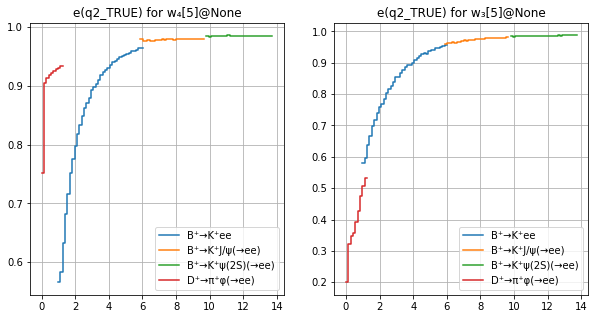

In [81]:
plot_e_all("q2_TRUE", results, np.linspace(0,14,101))

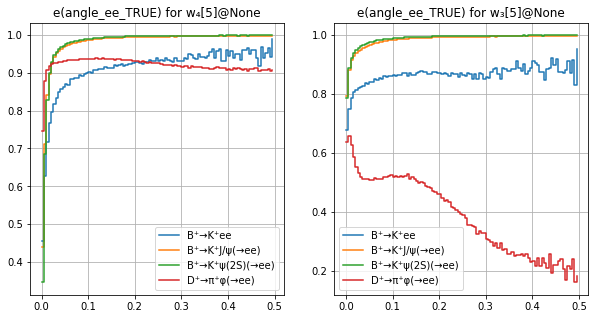

In [82]:
plot_e_all("angle_ee_TRUE", results, np.linspace(0,0.5,101))

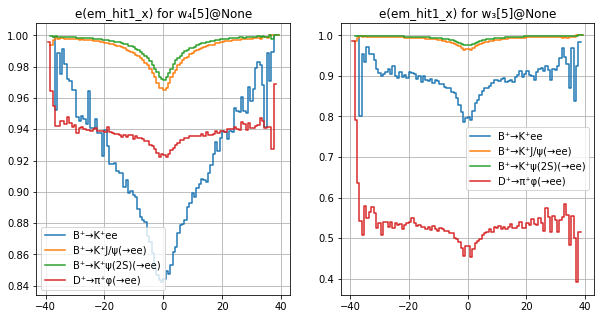

In [83]:
plot_e_all("em_hit1_x", results, np.linspace(-40,40,101))

### Blur

In [ ]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [ ]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

In [ ]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [ ]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [ ]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")